<a href="https://colab.research.google.com/github/Janina712/MLTSA_FinalProject/blob/main/Random_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pickle5

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import pickle5 as pickle
from pathlib import Path
import pylab as pl
from scipy import stats 
from scipy.stats import linregress
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from tensorflow import keras
from keras import layers 
from keras.layers import Dense, Input, Flatten,\
                   Reshape, LeakyReLU as LR,\
                   Activation, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras import backend as K
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/MLTSA22/Final_Project

/content/drive/MyDrive/MLTSA22/Final_Project


In [ ]:
!ls /content/drive/MyDrive/MLTSA22/Final_Project

00000258_s002_t000.edf
00010563_s002_t004.pkl
all_tuh_eeg_seizure_links.txt
curated_features_w_metadata_df.pkl
dev__01_tcp_ar__002__00000258__s002_2003_07_21__00000258_s002_t000.edf
dev__01_tcp_ar__002__00000258__s003_2003_07_22__00000258_s003_t001.edf
eval_balanced.pkl
eval.pkl
files_raw_channels_small_df.pkl
isip_tuh_eeg
seizures_types_v01.xlsx
temp
test_balanced.pkl
test.pkl
train_balanced.pkl
train.csv
train.pkl
tree.dot
tree.png


In [5]:
working_folder = Path('/content/drive/MyDrive/MLTSA22/Final_Project/')

In [6]:
with open(working_folder.joinpath('train_balanced.pkl'), "rb") as fh:
  train = pickle.load(fh)

In [7]:
with open(working_folder.joinpath('test_balanced.pkl'), "rb") as fh:
  eval = pickle.load(fh)

In [8]:
with open(working_folder.joinpath('eval_balanced.pkl'), "rb") as fh:
  test = pickle.load(fh)

In [9]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,label
37,-0.026240,0.263965,1.664255,-1.079515,0.513776,88.422233,66.0,-0.031126,0.524506,-0.072111,...,-0.408007,0.035609,-0.013427,18.046447,0.318961,0.054470,0.056403,0.042192,1.349573,False
55,-0.065516,0.769533,2.951503,-1.748289,0.877230,104.069223,30.0,0.685984,0.730153,-0.226620,...,-0.288996,0.070831,0.004161,28.132267,0.455210,0.133113,0.095850,0.044229,1.485900,False
57,0.034042,0.577843,2.802170,-1.837290,0.760160,103.469787,38.0,0.599843,0.285555,-0.009733,...,-0.561235,-0.224891,0.024703,23.023800,0.330814,0.144747,0.087539,0.046415,1.359942,False
108,-0.020617,0.849837,2.252118,-2.209114,0.921866,94.418940,51.0,-0.560592,-0.057938,0.032160,...,0.165283,-0.387099,0.022170,8.580930,0.655852,0.085866,0.087172,0.043534,1.609611,False
111,0.055645,1.202017,2.475360,-2.518906,1.096365,97.810244,39.0,-0.544213,-0.195984,0.164866,...,1.259412,-1.526448,-0.105420,114.126064,0.503182,0.098687,0.087039,0.043939,0.913309,False


We will try to run the RF on features: 1) as it is, 2) applying PCA, 3) after outliers removal

Here are the distributions of some of our features NAMES 

{'boxes': [<matplotlib.lines.Line2D at 0x7ffa8f6b3710>],
 'caps': [<matplotlib.lines.Line2D at 0x7ffa8f63d6d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ffa8f6456d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ffa8f645190>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ffa8f6b3c50>,
  <matplotlib.lines.Line2D at 0x7ffa8f63d190>]}

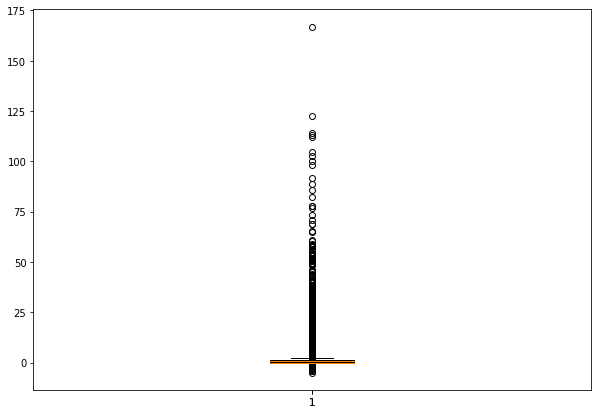

In [10]:
fig = pl.figure(figsize = (10,7))
pl.boxplot(train[0])
pl.boxplot(train[1])


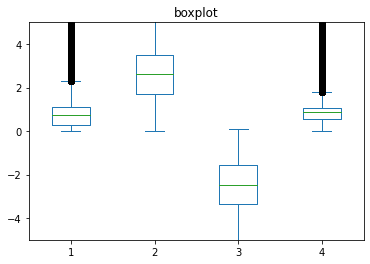

In [ ]:
ax = train[[1,2,3,4]].plot(kind='box', title='boxplot')
ax.set_ylim([-5, 5])
pl.show()

## Running RF as it is

In [ ]:
train_features, train_labels = train.loc[:, train.columns != 'label'], train['label']
test_features, test_labels = test.loc[:, test.columns != 'label'], test['label']
eval_features, eval_labels = eval.loc[:, eval.columns != 'label'], eval['label']

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Validation Features Shape:', eval_features.shape)
print('Validation Labels Shape:', eval_labels.shape)

Training Features Shape: (106336, 336)
Training Labels Shape: (106336,)
Testing Features Shape: (35828, 336)
Testing Labels Shape: (35828,)
Validation Features Shape: (54210, 336)
Validation Labels Shape: (54210,)


Creating subset of data for training and tuning parameters

In [ ]:
remove_n = round(int(train.shape[0]/3)) + 10000
drop_indices_False = np.random.choice(
    train[train['label'] == False].index, remove_n, replace=False
)
drop_indices_True = np.random.choice(
    train[train['label'] == True].index, remove_n, replace=False
)
train_subset = train.drop(drop_indices_False)
train_subset = train_subset.drop(drop_indices_True)

In [ ]:
remove_n

45445

In [ ]:
train_subset.shape

(15446, 337)

In [ ]:
train_s_features, train_s_labels = train_subset.loc[:, train_subset.columns != 'label'], train_subset['label']

In [ ]:
train_s_features.shape

(15446, 336)

RF fit

In [ ]:
rf = RandomForestClassifier(
    n_estimators = 600, random_state = 15, min_samples_leaf = 2, min_samples_split = 3, max_depth = 5
)
# Train the model on training data
rf.fit(train_s_features, train_s_labels);

In [ ]:
predictions = rf.predict(eval_features)

In [ ]:
train_score = rf.score(train_s_features, train_s_labels)
eval_score = rf.score(eval_features, eval_labels)
print('During training, the accuracy score was ' + str(round(train_score, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score, 3)))

During training, the accuracy score was 0.865
During validation, the accuracy score was 0.599


In [ ]:
print(classification_report(eval_labels, predictions))

              precision    recall  f1-score   support

       False       0.57      0.80      0.67     27105
        True       0.66      0.40      0.50     27105

    accuracy                           0.60     54210
   macro avg       0.62      0.60      0.58     54210
weighted avg       0.62      0.60      0.58     54210



In [ ]:
# FOR TOTAL SET
rf = RandomForestClassifier(
    n_estimators = 600, random_state = 15, min_samples_leaf = 2, min_samples_split = 3, max_depth = 5
)
# Train the model on training data
rf.fit(train_features, train_labels);

In [117]:
predictions = rf.predict(eval_features)

In [118]:
train_score = rf.score(train_features, train_labels)
eval_score = rf.score(eval_features, eval_labels)
print('During training, the accuracy score was ' + str(round(train_score, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score, 3)))

During training, the accuracy score was 0.746
During validation, the accuracy score was 0.612


In [119]:
print(classification_report(eval_labels, predictions))

              precision    recall  f1-score   support

       False       0.59      0.75      0.66     27105
        True       0.65      0.47      0.55     27105

    accuracy                           0.61     54210
   macro avg       0.62      0.61      0.60     54210
weighted avg       0.62      0.61      0.60     54210



In [120]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train.columns[:-1], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                   28 Importance: 0.04
Variable:                  171 Importance: 0.04
Variable:                   11 Importance: 0.03
Variable:                   12 Importance: 0.03
Variable:                   27 Importance: 0.03
Variable:                  251 Importance: 0.03
Variable:                   29 Importance: 0.02
Variable:                   59 Importance: 0.02
Variable:                   75 Importance: 0.02
Variable:                  107 Importance: 0.02
Variable:                  123 Importance: 0.02
Variable:                  155 Importance: 0.02
Variable:                  172 Importance: 0.02
Variable:                  175 Importance: 0.02
Variable:                  187 Importance: 0.02
Variable:                  188 Importance: 0.02
Variable:                  203 Importance: 0.02
Variable:                    7 Importance: 0.01
Variable:                   13 Importance: 0.01
Variable:                   31 Importance: 0.01
Variable:                   43 Importanc

In [121]:
cf_matrix = confusion_matrix(eval_labels, predictions)

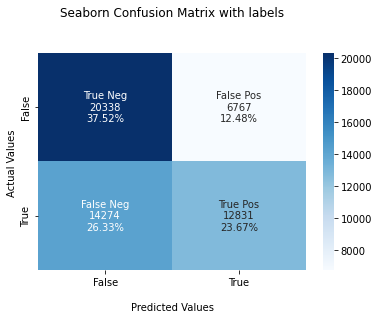

In [122]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

In [123]:
predictions_test = rf.predict(test_features)

In [124]:
test_score = rf.score(test_features, test_labels)
print('During test, the accuracy score was ' + str(round(test_score, 3)))

During test, the accuracy score was 0.639


In [125]:
print(classification_report(test_labels, predictions_test))

              precision    recall  f1-score   support

       False       0.60      0.83      0.70     17914
        True       0.72      0.45      0.55     17914

    accuracy                           0.64     35828
   macro avg       0.66      0.64      0.63     35828
weighted avg       0.66      0.64      0.63     35828



In [126]:
cf_matrix_test = confusion_matrix(test_labels, predictions_test)

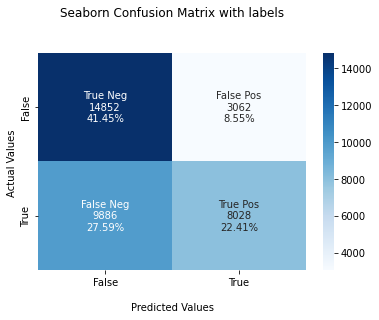

In [127]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

## PCA and RF

In [11]:
train_features, train_labels = train.loc[:, train.columns != 'label'], train['label']
test_features, test_labels = test.loc[:, test.columns != 'label'], test['label']
eval_features, eval_labels = eval.loc[:, eval.columns != 'label'], eval['label']

In [13]:
pca = PCA(n_components=100)
new_features = pca.fit_transform(train_features)
new_eval_features = pca.transform(eval_features)

In [14]:
# Instantiate model with 1000 decision trees
# n_estimators = 100 standard, won't cause overfitting but increases complexity
# max_depth - really important for accuracy, causes overfitiing
# We generally keep min_samples_split value between 2 and 6
# min_samples_leaf: less - overfitting, more - decreased number of parameters, basic - 1
rf_pca = RandomForestClassifier(
    n_estimators = 600, random_state = 42, min_samples_leaf = 1, min_samples_split = 3, max_depth = 8
)
# Train the model on training data
rf_pca.fit(new_features, train_labels);

In [15]:
# Use the forest's predict method on the test data
predictions_pca = rf_pca.predict(new_eval_features)

In [16]:
train_pca_score = rf_pca.score(new_features, train_labels)
eval_pca_score = rf_pca.score(new_eval_features, eval_labels)
print('During training, the accuracy score was ' + str(round(train_pca_score, 3)))
print('During validation, the accuracy score was ' + str(round(eval_pca_score, 3)))

During training, the accuracy score was 0.84
During validation, the accuracy score was 0.593


In [17]:
print(classification_report(eval_labels, predictions_pca))

              precision    recall  f1-score   support

       False       0.56      0.83      0.67     27105
        True       0.68      0.35      0.47     27105

    accuracy                           0.59     54210
   macro avg       0.62      0.59      0.57     54210
weighted avg       0.62      0.59      0.57     54210



In [ ]:
# plot pca components

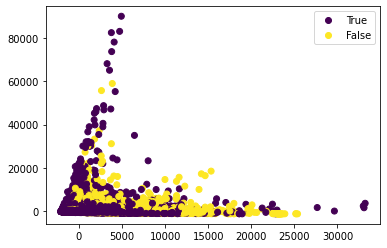

In [27]:
plot = pl.scatter(new_features[:,0], new_features[:,1], c=train_labels)
pl.legend(handles=plot.legend_elements()[0], labels=list([True, False]))
pl.show()

In [29]:
cf_pca_matrix = confusion_matrix(eval_labels, predictions_pca)

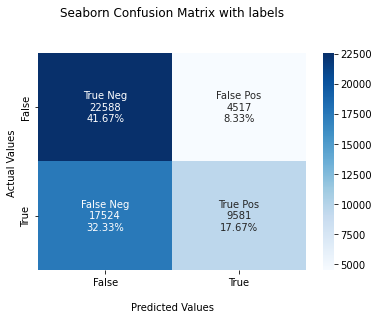

In [30]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_pca_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_pca_matrix.flatten()/np.sum(cf_pca_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_pca_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

## Data without outliers RF

In [31]:
feature_col = train.columns
feature_col = feature_col[:-1]

In [90]:
train_scale = train.copy()
eval_scale = eval.copy()
test_scale = test.copy()

In [91]:
train_scale['set'] = 'train'
eval_scale['set'] = 'eval'
test_scale['set'] = 'test'

In [92]:
all_together = pd.concat([train_scale, eval_scale])

In [93]:
all_together = pd.concat([all_together, test_scale])

In [94]:
all_together.shape

(196374, 338)

In [95]:
 # removing outliers outside upper and lower limits 
for col in all_together.columns[:-2]:
  q75 = np.percentile(all_together[col], 75)
  q25 = np.percentile(all_together[col], 25)
  intr_qr = q75 - q25
  upper = q75 + (intr_qr*1.5)
  lower = q25 - (intr_qr*1.5)
  col_values = all_together[col].values
  col_new = []
  for value in col_values:
    if value < lower:
      col_new.append(np.nan)
    elif value > upper:
      col_new.append(np.nan)
    else:
      col_new.append(value)
  all_together[col] = col_new

In [96]:
all_together[50].isnull().sum()

10653

In [97]:
all_together.shape

(196374, 338)

In [98]:
all_without = all_together.dropna(axis='index')

In [99]:
train_without = all_without[all_without['set'] == 'train']
eval_without = all_without[all_without['set'] == 'eval']
test_without = all_without[all_without['set'] == 'test']

In [100]:
print(train_without.shape)
print(eval_without.shape)
print(test_without.shape)

(8457, 338)
(6291, 338)
(4140, 338)


In [101]:
print(
    '% of positive samples in train: ',
    train_without[train_without['label'] == True].shape[0] / train_without.shape[0] * 100
)
print(
    '% of positive samples in eval: ',
    eval_without[eval_without['label'] == True].shape[0] / eval_without.shape[0] * 100
)
print(
    '% of positive samples in test: ',
    test_without[test_without['label'] == True].shape[0] / test_without.shape[0] * 100
)

% of positive samples in train:  45.42982144968665
% of positive samples in eval:  52.58305515816245
% of positive samples in test:  49.75845410628019


In [102]:
train_without = train_without[train_without.columns[:-1]]
eval_without = eval_without[eval_without.columns[:-1]]
test_without = test_without[test_without.columns[:-1]]

In [103]:
train_wo_features, train_wo_labels = train_without.loc[:, train_without.columns != 'label'], train_without['label']
test_wo_features, test_wo_labels = test_without.loc[:, test_without.columns != 'label'], test_without['label']
eval_wo_features, eval_wo_labels = eval_without.loc[:, eval_without.columns != 'label'], eval_without['label']

In [105]:
print('Training Features Shape:', train_wo_features.shape)
print('Training Labels Shape:', train_wo_labels.shape)
print('Testing Features Shape:', test_wo_features.shape)
print('Testing Labels Shape:', test_wo_labels.shape)
print('Validation Features Shape:', eval_wo_features.shape)
print('Validation Labels Shape:', eval_wo_labels.shape)

Training Features Shape: (8457, 336)
Training Labels Shape: (8457,)
Testing Features Shape: (4140, 336)
Testing Labels Shape: (4140,)
Validation Features Shape: (6291, 336)
Validation Labels Shape: (6291,)


In [117]:
rf_wo = RandomForestClassifier(
    n_estimators = 600, random_state = 30, min_samples_leaf = 2, min_samples_split = 2, max_depth = 6
)
# Train the model on training data
rf_wo.fit(train_wo_features, train_wo_labels);

In [118]:
predictions_wo = rf_wo.predict(eval_wo_features)

In [119]:
train_wo_score = rf_wo.score(train_wo_features, train_wo_labels)
eval_wo_score = rf_wo.score(eval_wo_features, eval_wo_labels)
print('During training, the accuracy score was ' + str(round(train_wo_score, 3)))
print('During validation, the accuracy score was ' + str(round(eval_wo_score, 3)))

During training, the accuracy score was 0.885
During validation, the accuracy score was 0.54


In [120]:
print(classification_report(eval_wo_labels, predictions_wo))

              precision    recall  f1-score   support

       False       0.51      0.92      0.65      2983
        True       0.73      0.20      0.31      3308

    accuracy                           0.54      6291
   macro avg       0.62      0.56      0.48      6291
weighted avg       0.62      0.54      0.48      6291



In [123]:
# Get numerical feature importances
importances = list(rf_wo.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_wo_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                   12 Importance: 0.02
Variable:                   13 Importance: 0.02
Variable:                   28 Importance: 0.02
Variable:                   29 Importance: 0.02
Variable:                  141 Importance: 0.02
Variable:                  157 Importance: 0.02
Variable:                  203 Importance: 0.02
Variable:                  219 Importance: 0.02
Variable:                  277 Importance: 0.02
Variable:                  286 Importance: 0.02
Variable:                    5 Importance: 0.01
Variable:                   11 Importance: 0.01
Variable:                   21 Importance: 0.01
Variable:                   27 Importance: 0.01
Variable:                   30 Importance: 0.01
Variable:                   38 Importance: 0.01
Variable:                   69 Importance: 0.01
Variable:                   75 Importance: 0.01
Variable:                   76 Importance: 0.01
Variable:                   77 Importance: 0.01
Variable:                   91 Importanc

In [124]:
cf_matrix_wo = confusion_matrix(eval_wo_labels, predictions_wo)

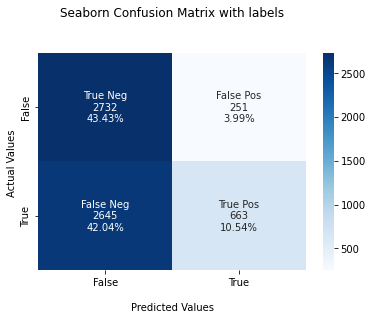

In [125]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_wo.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_wo.flatten()/np.sum(cf_matrix_wo)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_wo, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

In [126]:
predictions_wo_test = rf_wo.predict(test_wo_features)

In [127]:
test_wo_score = rf_wo.score(test_wo_features, test_wo_labels)
print('During training, the accuracy score was ' + str(round(test_wo_score, 3)))
print(classification_report(test_wo_labels, predictions_wo_test))

During training, the accuracy score was 0.572
              precision    recall  f1-score   support

       False       0.55      0.89      0.68      2080
        True       0.69      0.25      0.37      2060

    accuracy                           0.57      4140
   macro avg       0.62      0.57      0.52      4140
weighted avg       0.62      0.57      0.52      4140



In [128]:
cf_matrix_wo_test = confusion_matrix(test_wo_labels, predictions_wo_test)

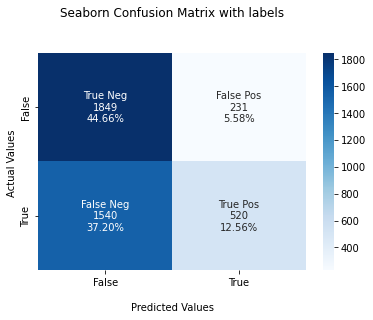

In [129]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_wo_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_wo_test.flatten()/np.sum(cf_matrix_wo_test)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix_wo_test, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

## Additional. Not necessary now

In [ ]:
for col in feature_col:
  new_values = (train_scale[col].values - train_scale[col].values.mean())/train_scale[col].values.std() 
  train_scale[col] = new_values
  new_values1 = (eval_scale[col].values - eval_scale[col].values.mean())/eval_scale[col].values.std() 
  eval_scale[col] = new_values1
  new_values2 = (test_scale[col].values - test_scale[col].values.mean())/test_scale[col].values.std() 
  test_scale[col] = new_values2


{'boxes': [<matplotlib.lines.Line2D at 0x7f83f973e710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f83b41f8510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f83b41f1550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f83b41f8fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f83f9541a50>,
  <matplotlib.lines.Line2D at 0x7f83f9541f90>]}

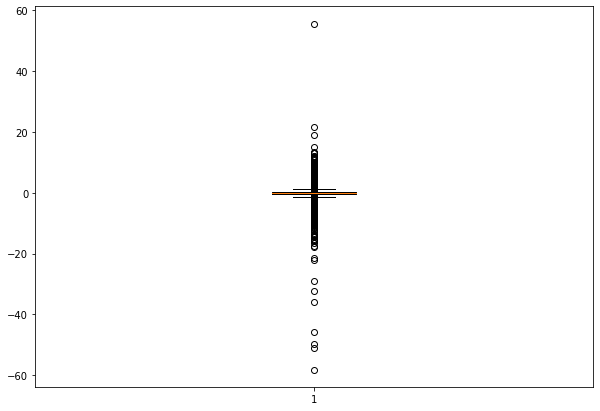

In [ ]:
fig = pl.figure(figsize = (10,7))
pl.boxplot(train_scale[0])

In [ ]:
train_features, train_labels = train.loc[:, train.columns != 'label'], train['label']
test_features, test_labels = test.loc[:, test.columns != 'label'], test['label']
eval_features, eval_labels = eval.loc[:, eval.columns != 'label'], eval['label']

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Validation Features Shape:', eval_features.shape)
print('Validation Labels Shape:', eval_labels.shape)

Training Features Shape: (106336, 336)
Training Labels Shape: (106336,)
Testing Features Shape: (54210, 336)
Testing Labels Shape: (54210,)
Validation Features Shape: (35828, 336)
Validation Labels Shape: (35828,)


In [ ]:
std_f_True = []
mean_f_True = []
std_f_False = []
mean_f_False = []
for col in feature_col:
  data1 = train_scale[train_scale['label'] == True]
  data2 = train_scale[train_scale['label'] == False]
  mean_f_True.append(data1[col].values.mean())
  std_f_True.append(data1[col].values.std())
  mean_f_False.append(data2[col].values.mean())
  std_f_False.append(data2[col].values.std())

In [ ]:
std_eval_True = []
mean_eval_True = []
std_eval_False = []
mean_eval_False = []
for col in feature_col:
  data1 = eval_scale[eval_scale['label'] == True]
  data2 = eval_scale[eval_scale['label'] == False]
  mean_eval_True.append(data1[col].values.mean())
  std_eval_True.append(data1[col].values.std())
  mean_eval_False.append(data2[col].values.mean())
  std_eval_False.append(data2[col].values.std())

No handles with labels found to put in legend.


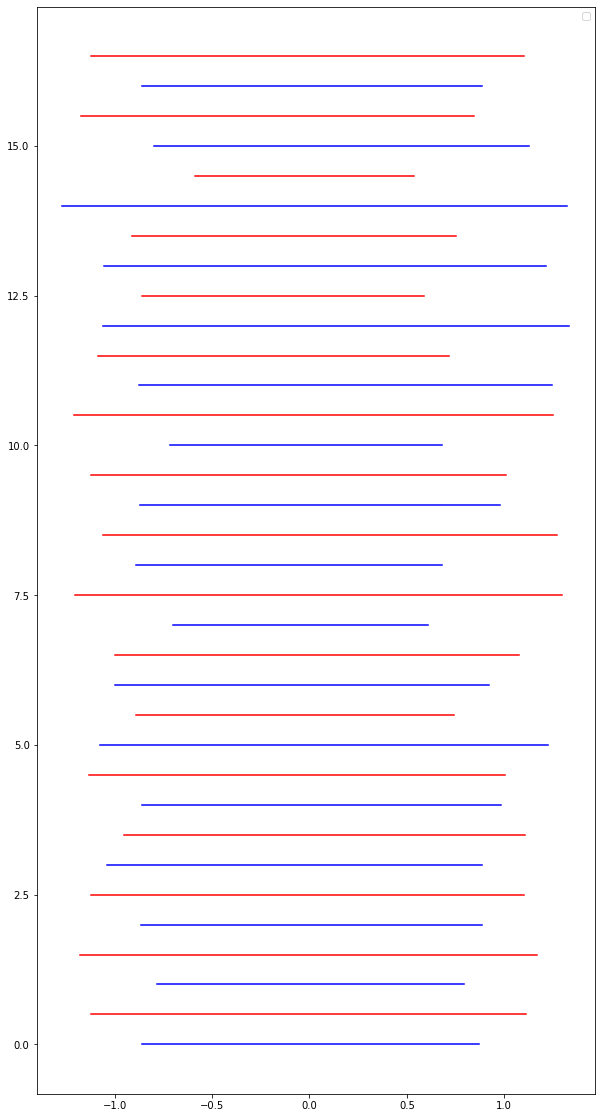

In [ ]:
pl.figure(figsize = (10,20))
for feature_index, (value0, value1) in enumerate(zip(mean_f_True[:17], std_f_True[:17])):
  y = [feature_index]*3
  tmp = [value0 - value1, value0, value0 + value1]
  pl.plot(tmp, y, color = 'blue')
for feature_index, (value0, value1) in enumerate(zip(mean_f_False[:17], std_f_False[:17])):
  y = [feature_index + 0.5]*3
  tmp = [value0 - value1, value0, value0 + value1]
  pl.plot(tmp, y, color = 'red')
'''for feature_index, (value0, value1) in enumerate(zip(mean_eval_True[:12], std_eval_True[:12])):
  y = [feature_index + 0.5]*3
  tmp = [value0 - value1, value0, value0 + value1]
  pl.plot(tmp, y, color = 'green')
for feature_index, (value0, value1) in enumerate(zip(mean_eval_False[:12], std_eval_False[:12])):
  y = [feature_index + 0.75]*3
  tmp = [value0 - value1, value0, value0 + value1]
  pl.plot(tmp, y, color = 'black')'''
pl.legend();

# Round 2

In [ ]:
# Instantiate model with 1000 decision trees
# n_estimators = 100 standard, won't cause overfitting but increases complexity
# max_depth - really important for accuracy, causes overfitiing
# We generally keep min_samples_split value between 2 and 6
# min_samples_leaf: less - overfitting, more - decreased number of parameters, basic - 1
rf1 = RandomForestClassifier(
    n_estimators = 600, random_state = 20, min_samples_leaf = 5, min_samples_split = 2, max_depth = 8
)
# Train the model on training data
rf1.fit(train_s_features, train_s_labels);

In [ ]:
predictions1 = rf1.predict(eval_features)

In [ ]:
train_score1 = rf1.score(train_s_features, train_s_labels)
eval_score1 = rf1.score(eval_features, eval_labels)

In [ ]:
print('During training, the accuracy score was ' + str(round(train_score1, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score1, 3)))

During training, the accuracy score was 0.861
During validation, the accuracy score was 0.652


              precision    recall  f1-score   support

       False       0.61      0.87      0.71     17914
        True       0.77      0.44      0.56     17914

    accuracy                           0.65     35828
   macro avg       0.69      0.65      0.64     35828
weighted avg       0.69      0.65      0.64     35828



In [ ]:
accuracy_score(eval_labels, predictions1)

0.6568605559897287

In [ ]:
cf_matrix1 = confusion_matrix(eval_labels, predictions1)

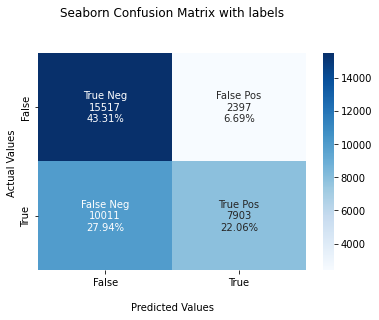

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix1.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

Round ... 

In [ ]:
remove_n = round(int(train.shape[0]/3)) + 10000
drop_indices_False = np.random.choice(
    train[train['label'] == False].index, remove_n, replace=False
)
drop_indices_True = np.random.choice(
    train[train['label'] == True].index, remove_n, replace=False
)
train_subset = train.drop(drop_indices_False)
train_subset = train_subset.drop(drop_indices_True)

In [ ]:
train_subset.shape

(15446, 337)

In [ ]:
train_s_features, train_s_labels = train_subset.loc[:, train_subset.columns != 'label'], train_subset['label']

In [ ]:
train_s_features.shape

(15446, 336)

In [ ]:
# Instantiate model with 1000 decision trees
# n_estimators = 100 standard, won't cause overfitting but increases complexity
# max_depth - really important for accuracy, causes overfitiing
# We generally keep min_samples_split value between 2 and 6
# min_samples_leaf: less - overfitting, more - decreased number of parameters, basic - 1
rf2 = RandomForestClassifier(
    n_estimators = 600, random_state = 10, min_samples_leaf = 1, max_depth = 400
)
# Train the model on training data
rf2.fit(train_s_features, train_s_labels);

In [ ]:
predictions2 = rf2.predict(eval_features)

In [ ]:
train_score2 = rf2.score(train_s_features, train_s_labels)
eval_score2 = rf2.score(eval_features, eval_labels)

In [ ]:
print('During training, the accuracy score was ' + str(round(train_score2, 3)))
print('During validation, the accuracy score was ' + str(round(eval_score2, 3)))
print(classification_report(eval_labels, predictions2))

During training, the accuracy score was 1.0
During validation, the accuracy score was 0.657
              precision    recall  f1-score   support

       False       0.60      0.91      0.73     17914
        True       0.82      0.40      0.54     17914

    accuracy                           0.66     35828
   macro avg       0.71      0.66      0.63     35828
weighted avg       0.71      0.66      0.63     35828



In [ ]:
cf_matrix2 = confusion_matrix(eval_labels, predictions2)

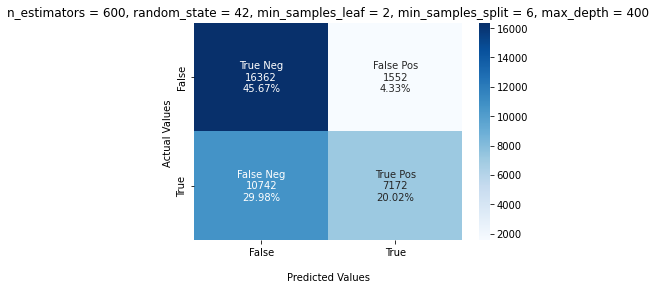

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix1.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')

ax.set_title('n_estimators = 600, random_state = 42, min_samples_leaf = 2, min_samples_split = 6, max_depth = 400');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()

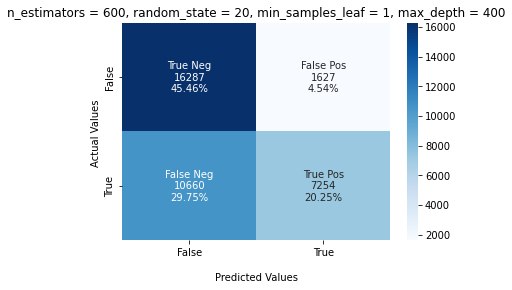

In [ ]:
cf_matrix3 = confusion_matrix(eval_labels, predictions2)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix3.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix3.flatten()/np.sum(cf_matrix3)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix3, annot=labels, fmt='', cmap='Blues')

ax.set_title('n_estimators = 600, random_state = 20, min_samples_leaf = 1, max_depth = 400');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
pl.show()